<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [52]:
#Here, I am playing around with this assignment and trying some stuff that wasn't suggested.
#The major change is that the original lab breaks one of the main rules I've read for machine learning.
#It is a general rule of thumb that your training X data should have 10X as many rows as columns... otherwise you don't 
#have enough data points to properly handle the large number of degrees of freedom (i.e. more complex models require more data).
#So I've now restricted the X data to use only 7 features in the X data. The models are now differentiated from one another in
#terms of performance, while they all performed similarly in the original lab. Logistic regression also performed better in this
#version than any model in the original lab.

In [1]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

We will import the following libraries for the lab


In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

This function is to plot the confusion matrix.


In [3]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [4]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [5]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [7]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
Xraw = pd.read_csv(text2)

In [8]:
#Xraw.head(100)
Xraw.columns

Index(['FlightNumber', 'PayloadMass', 'Flights', 'Block', 'ReusedCount',
       'Orbit_ES-L1', 'Orbit_GEO', 'Orbit_GTO', 'Orbit_HEO', 'Orbit_ISS',
       'Orbit_LEO', 'Orbit_MEO', 'Orbit_PO', 'Orbit_SO', 'Orbit_SSO',
       'Orbit_VLEO', 'LaunchSite_CCAFS SLC 40', 'LaunchSite_KSC LC 39A',
       'LaunchSite_VAFB SLC 4E', 'LandingPad_5e9e3032383ecb267a34e7c7',
       'LandingPad_5e9e3032383ecb554034e7c9',
       'LandingPad_5e9e3032383ecb6bb234e7ca',
       'LandingPad_5e9e3032383ecb761634e7cb',
       'LandingPad_5e9e3033383ecbb9e534e7cc', 'Serial_B0003', 'Serial_B0005',
       'Serial_B0007', 'Serial_B1003', 'Serial_B1004', 'Serial_B1005',
       'Serial_B1006', 'Serial_B1007', 'Serial_B1008', 'Serial_B1010',
       'Serial_B1011', 'Serial_B1012', 'Serial_B1013', 'Serial_B1015',
       'Serial_B1016', 'Serial_B1017', 'Serial_B1018', 'Serial_B1019',
       'Serial_B1020', 'Serial_B1021', 'Serial_B1022', 'Serial_B1023',
       'Serial_B1025', 'Serial_B1026', 'Serial_B1028', 'Serial_B102

## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [9]:
Y=data['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [29]:
# students get this 
X=Xraw[['PayloadMass', 'FlightNumber', 'ReusedCount', 'Block', 'LaunchSite_CCAFS SLC 40', 'LaunchSite_KSC LC 39A',
       'LaunchSite_VAFB SLC 4E']]
X = preprocessing.StandardScaler().fit(X).transform(X)
X

array([[-1.94814463e-16, -1.71291154e+00, -9.73440458e-01,
        -1.57589457e+00,  7.97724035e-01, -5.68796459e-01,
        -4.10890702e-01],
       [-1.19523159e+00, -1.67441914e+00, -9.73440458e-01,
        -1.57589457e+00,  7.97724035e-01, -5.68796459e-01,
        -4.10890702e-01],
       [-1.16267307e+00, -1.63592675e+00, -9.73440458e-01,
        -1.57589457e+00,  7.97724035e-01, -5.68796459e-01,
        -4.10890702e-01],
       [-1.20058661e+00, -1.59743435e+00, -9.73440458e-01,
        -1.57589457e+00, -1.25356634e+00, -5.68796459e-01,
         2.43373723e+00],
       [-6.28670558e-01, -1.55894196e+00, -9.73440458e-01,
        -1.57589457e+00,  7.97724035e-01, -5.68796459e-01,
        -4.10890702e-01],
       [-5.95469439e-01, -1.52044957e+00, -9.73440458e-01,
        -1.57589457e+00,  7.97724035e-01, -5.68796459e-01,
        -4.10890702e-01],
       [-8.15882029e-01, -1.48195717e+00, -9.73440458e-01,
        -1.57589457e+00,  7.97724035e-01, -5.68796459e-01,
        -4.1089070

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [31]:
#Y_test.shape
X_train.shape

(72, 7)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [32]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [33]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters,cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [34]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.7214285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [35]:
logreg_cv.score(X_test, Y_test)

0.8888888888888888

Lets look at the confusion matrix:


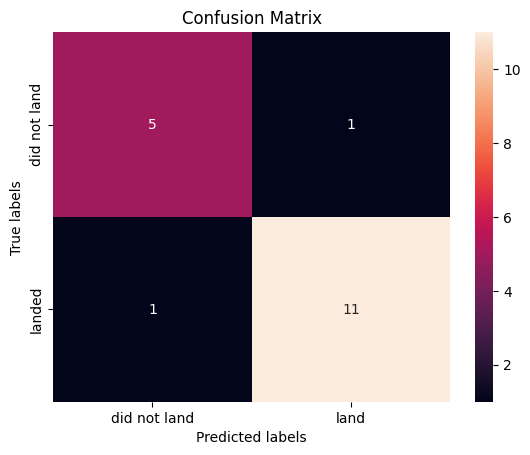

In [36]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [37]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [38]:
svm_cv = GridSearchCV(svm, parameters,cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [39]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
accuracy : 0.7946428571428571


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [40]:
svm_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


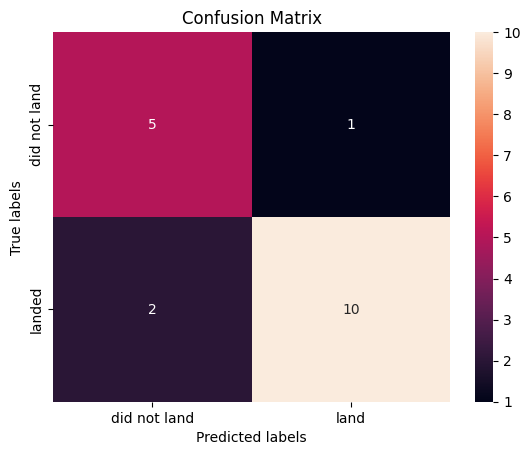

In [41]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [42]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [43]:
tree_cv = GridSearchCV(tree, parameters,cv=10)
tree_cv.fit(X_train, Y_train)

/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: 

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [44]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.8160714285714284


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [45]:
tree_cv.score(X_test, Y_test)

0.6111111111111112

We can plot the confusion matrix


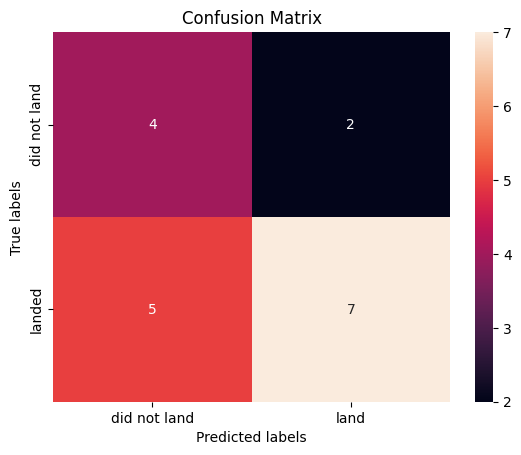

In [46]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [47]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [48]:
knn_cv = GridSearchCV(KNN, parameters,cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [49]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}
accuracy : 0.7803571428571429


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [50]:
knn_cv.score(X_test, Y_test)

0.7777777777777778

We can plot the confusion matrix


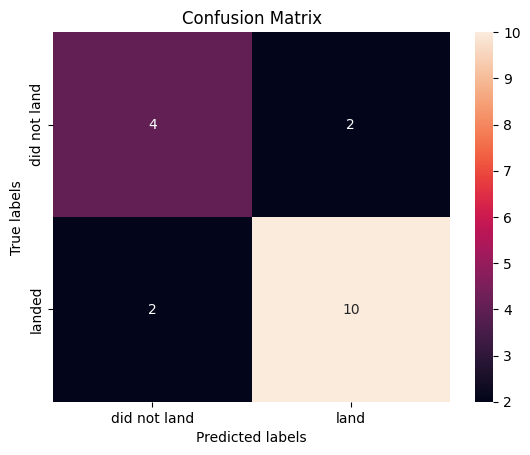

In [51]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:


## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
